In [18]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.hmm.graphical_models import DynamicBayesianNetwork as dbn
from hela.hmm.graphical_models import structured_inference as dbn_inf

In [19]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2, 2],
                                     n_gaussian_features = 1,
                                     n_categorical_features = 0)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

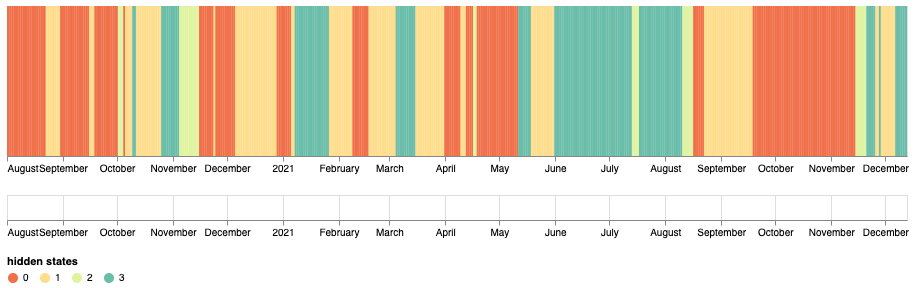

In [20]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [21]:
fhmm_data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   fhmm_data,
#                                    categorical_features = list(gen.categorical_values.columns),
                                   categorical_features = [],
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

fhmm_model = fhmm_config.to_model()

In [ ]:
fhmm_data.head()

In [17]:
fhmm_model.initial_state_matrix[0]

masked_array(data=[0.0, 1.0],
             mask=[False, False],
       fill_value=1e+20)

In [7]:
fhmm_model.transition_matrix

array([[[0.94680851, 0.05319149],
        [0.01234568, 0.98765432]],

       [[0.98909091, 0.01090909],
        [0.01785714, 0.98214286]]])

In [23]:
fhmm_model.gaussian_model.means[0].shape

(1, 2)

In [8]:
def f_b(model, data, h_t):
    time = len(data)
    systems = len(model.ns_hidden_states)
    n = np.max(model.ns_hidden_states)
    alpha = np.zeros((time,systems,n))
    beta = np.zeros((time,systems,n))
    prob = np.zeros((time,systems,n))
    #initialize alpha and beta
    alpha[0][:][:] = h_t[0][:][:] * model.initial_state_matrix
    beta[time-1][0][:] = np.ones(len(model.ns_hidden_states))
    beta[time-1][1][:] = np.ones(len(model.ns_hidden_states))
    for m in range(systems):
        for t in range(1, time):
            alpha[t][m][:] = h_t[t][m][:]*np.dot(alpha[t-1][m][:], fhmm_model.transition_matrix[m])
        #backward
        for t in range(time-2, -1, -1):
            beta[t][m][:] = np.sum(h_t[t+1][m] * fhmm_model.transition_matrix[m] * beta[t+1][m][:], axis=1)
        #new prob for system
        prob[:,m,:] = np.divide(alpha[:,m,:]*beta[:,m,:], 
                                      np.sum(alpha[:,m,:]*beta[:,m,:], axis=1).reshape(-1,1))
    return prob

def h_t_update(model, prob, data):
    inv_cov = np.linalg.inv(model.gaussian_model.covariance)
    gauss_data = np.array(data.loc[:, model.gaussian_features])
    h_t_new = np.zeros((len(data), 
                        len(model.ns_hidden_states), 
                        np.max(model.ns_hidden_states)))
    systems = len(model.ns_hidden_states)
    for m in range(systems):
        mean = model.gaussian_model.means[m]
        delta = (mean.T @ inv_cov @ mean).diagonal()
        other_systems = [i for i in range(systems) if i != m]
        error = np.zeros(gauss_data.T.shape)
        for system in other_systems:
            # todo: double check correctness
            error += np.tensordot(model.gaussian_model.means[system],
                                           prob[:,system,:], axes=((1,1)))
        residual_error = gauss_data.T - error
        #TODO rename
        temp = np.tensordot(np.tensordot(residual_error, inv_cov, axes=((0,1))), 
                            mean, axes=((1,1)))
        h_t_new[:,m,:] = np.exp(-delta/2 + temp)
    return h_t_new

In [9]:
h_t = np.ones((len(fhmm_data), 
                        len(fhmm_model.ns_hidden_states), 
                        np.max(fhmm_model.ns_hidden_states)))/np.max(fhmm_model.ns_hidden_states)
for i in range(15):
    prob = f_b(fhmm_model, fhmm_data, h_t)
    h_t = h_t_update(fhmm_model, prob, fhmm_data)

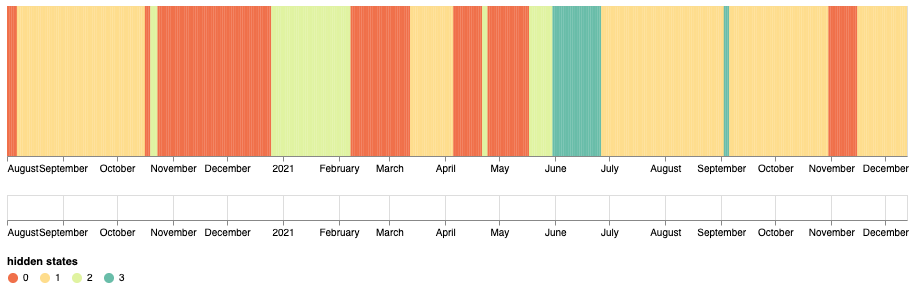

In [10]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

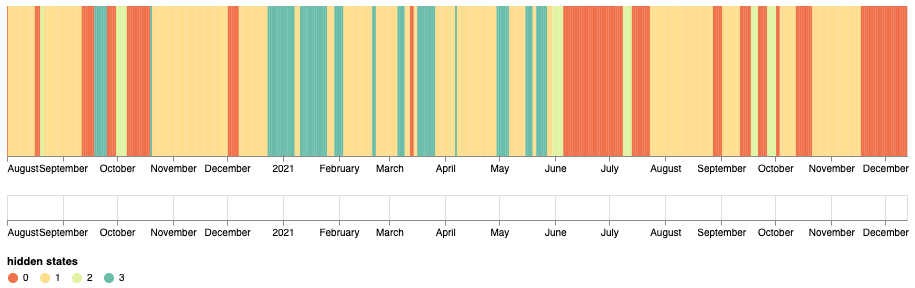

In [11]:
naive_predicted_states = [np.array([np.argmax(prob[:,0,:], axis=1)[i], 
                                   np.argmax(prob[:,1,:], axis=1)[i]])
                                   for i in range(prob.shape[0])]

states = pd.DataFrame(np.array(naive_predicted_states), index=fhmm_data.index)
flattened_pred_states = gen.flatten_hidden_state_sequence(states)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [12]:
flattened_pred_states

2020-08-01    0
2020-08-02    1
2020-08-03    1
2020-08-04    1
2020-08-05    1
             ..
2021-12-09    0
2021-12-10    0
2021-12-11    0
2021-12-12    0
2021-12-13    0
Freq: D, Length: 500, dtype: int64

In [13]:
flattened_hidden_states

2020-08-01    0
2020-08-02    0
2020-08-03    0
2020-08-04    0
2020-08-05    0
             ..
2021-12-09    1
2021-12-10    1
2021-12-11    1
2021-12-12    1
2021-12-13    1
Freq: D, Length: 500, dtype: int64

In [14]:
states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,1
...,...,...
2021-12-09,0,0
2021-12-10,0,0
2021-12-11,0,0
2021-12-12,0,0


In [15]:
factored_hidden_states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,1
...,...,...
2021-12-09,0,0
2021-12-10,0,0
2021-12-11,0,0
2021-12-12,0,0


In [10]:
# # TODO: can be parallelized using dask
# alpha[0][:][:] = h_t[0][:][:] * fhmm_model.initial_state_matrix
# beta[time-1][0][:] = np.ones(len(fhmm_model.ns_hidden_states))
# beta[time-1][1][:] = np.ones(len(fhmm_model.ns_hidden_states))
# for m in range(systems):
#     for t in range(1, time):
#         alpha[t][m][:] = h_t[t][m][:]*np.dot(alpha[t-1][m][:], fhmm_model.transition_matrix[m])
#     for t in range(time-2, -1, -1):
#         beta[t][m][:] = np.sum(h_t[t+1][m] * fhmm_model.transition_matrix[m] * beta[t+1][m][:], axis=1)
#     likelihood[:,m,:] = np.divide(alpha[:,m,:]*beta[:,m,:], np.sum(alpha[:,m,:]*beta[:,m,:], axis=1).reshape(-1,1))

In [11]:
# h_t = np.zeros(alpha.shape)
# inv_cov = np.linalg.inv(fhmm_model.gaussian_model.covariance)
# gauss_data = np.array(fhmm_data.loc[:, fhmm_model.gaussian_features])
# for m in range(systems):
#     mean = fhmm_model.gaussian_model.means[m]
#     delta = (mean.T @ inv_cov @ mean).diagonal()
#     other_systems = [i for i in range(systems) if i != m]
#     error = np.zeros(gauss_data.T.shape)
#     for system in other_systems:
#         # todo: double check correctness
#         error += np.tensordot(fhmm_model.gaussian_model.means[system],
#                                        likelihood[:,system,:], axes=((1,1)))
#     residual_error = gauss_data.T - error
#     temp = np.tensordot(np.tensordot(residual_error, inv_cov, axes=((0,1))), 
#                         mean, axes=((1,1)))
#     h_t[:,m,:] = np.exp(-delta/2 + temp)

In [53]:
# time = len(fhmm_data)
# systems = len(fhmm_model.ns_hidden_states)
# n = np.max(fhmm_model.ns_hidden_states)
# alpha = np.zeros((time,systems,n))
# beta = np.zeros((time,systems,n))
# likelihood = np.zeros((time,systems,n))
# h_t = np.ones((time,systems,n))/n

In [132]:
# likelihoods = []
# errors = []
# h_t = np.ones((time,systems,n))/n
# # h_t = np.zeros(alpha.shape)
# for i in range(10):
#     alpha = np.zeros((time,systems,n))
#     beta = np.zeros((time,systems,n))
#     prob = np.zeros((time,systems,n))
#     #initialize alpha and beta
#     alpha[0][:][:] = h_t[0][:][:] * fhmm_model.initial_state_matrix
#     beta[time-1][0][:] = np.ones(len(fhmm_model.ns_hidden_states))
#     beta[time-1][1][:] = np.ones(len(fhmm_model.ns_hidden_states))
#     #forward backward
#     for m in range(systems):
#         print(h_t[300][m][:])
#         #forward
#         for t in range(1, time):
#             alpha[t][m][:] = h_t[t][m][:]*np.dot(alpha[t-1][m][:], fhmm_model.transition_matrix[m])
#         #backward
#         for t in range(time-2, -1, -1):
#             beta[t][m][:] = np.sum(h_t[t+1][m] * fhmm_model.transition_matrix[m] * beta[t+1][m][:], axis=1)
#         #new prob for system
#         prob[:,m,:] = np.divide(alpha[:,m,:]*beta[:,m,:], 
#                                       np.sum(alpha[:,m,:]*beta[:,m,:], axis=1).reshape(-1,1))
#     likelihoods.append(prob)
#     inv_cov = np.linalg.inv(fhmm_model.gaussian_model.covariance)
#     gauss_data = np.array(fhmm_data.loc[:, fhmm_model.gaussian_features])
#     h_t_new = np.zeros(h_t.shape)
#     for m in range(systems):
#         mean = fhmm_model.gaussian_model.means[m]
#         delta = (mean.T @ inv_cov @ mean).diagonal()
#         other_systems = [i for i in range(systems) if i != m]
#         error = np.zeros(gauss_data.T.shape)
#         for system in other_systems:
#             # todo: double check correctness
#             error += np.tensordot(fhmm_model.gaussian_model.means[system],
#                                            prob[:,system,:], axes=((1,1)))
#         residual_error = gauss_data.T - error
#         #TODO rename
#         temp = np.tensordot(np.tensordot(residual_error, inv_cov, axes=((0,1))), 
#                             mean, axes=((1,1)))
#         errors.append(-delta/2 + temp)
#         h_t_new[:,m,:] = np.exp(-delta/2 + temp)
#     print("___________"*3)
#     h_t = h_t_new

[0.5 0.5]
[0.5 0.5]
_________________________________
[0.09193749 0.09505427]
[0.34527631 0.40618297]
_________________________________
[0.04869422 0.04559416]
[0.31280314 0.61085197]
_________________________________
[0.03325321 0.02933807]
[0.30761184 0.65457947]
_________________________________
[0.03267419 0.02874836]
[0.30341211 0.69283001]
_________________________________
[0.03206146 0.02812609]
[0.30344983 0.6924743 ]
_________________________________
[0.03206837 0.0281331 ]
[0.3030223  0.69651947]
_________________________________
[0.0320115  0.02807543]
[0.30303321 0.69641586]
_________________________________
[0.03201297 0.02807692]
[0.30298791 0.69684612]
_________________________________
[0.03200701 0.02807087]
[0.30298926 0.69683335]
_________________________________


In [10]:
fhmm_model.hidden_state_enum_to_vector

{0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}

In [11]:
fhmm_model.hidden_state_vector_to_enum

{'[0, 0]': 0, '[0, 1]': 1, '[1, 0]': 2, '[1, 1]': 3}

In [12]:
cat_data = np.array(fhmm_data.loc[:, fhmm_model.categorical_features])

In [13]:
cat_data

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [14]:
fhmm_model.categorical_model.emission_matrix

array([[0.8       , 0.0625    , 0.81707317, 0.8625    ],
       [0.2       , 0.9375    , 0.18292683, 0.1375    ]])

In [13]:
states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,0
...,...,...
2021-12-09,0,0
2021-12-10,0,0
2021-12-11,0,0
2021-12-12,0,0


In [14]:
factored_hidden_states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,1
...,...,...
2021-12-09,0,0
2021-12-10,0,0
2021-12-11,0,0
2021-12-12,0,0


In [15]:
prob[:,0,:]
#t=0 -> hs = [0 1]


array([[0.00000000e+00, 1.00000000e+00],
       [7.91911024e-03, 9.92080890e-01],
       [1.02021135e-02, 9.89797887e-01],
       [7.66251053e-03, 9.92337489e-01],
       [7.74489902e-03, 9.92255101e-01],
       [5.25253792e-03, 9.94747462e-01],
       [5.02005477e-04, 9.99497995e-01],
       [2.28044944e-04, 9.99771955e-01],
       [4.24367530e-05, 9.99957563e-01],
       [2.91011537e-05, 9.99970899e-01],
       [4.40797168e-05, 9.99955920e-01],
       [1.18515910e-04, 9.99881484e-01],
       [2.65078585e-05, 9.99973492e-01],
       [1.32290722e-04, 9.99867709e-01],
       [2.61951758e-05, 9.99973805e-01],
       [9.38195087e-05, 9.99906180e-01],
       [2.03385887e-05, 9.99979661e-01],
       [7.77312678e-05, 9.99922269e-01],
       [4.64912065e-06, 9.99995351e-01],
       [5.74559959e-05, 9.99942544e-01],
       [1.14021756e-05, 9.99988598e-01],
       [1.37049620e-05, 9.99986295e-01],
       [6.98059366e-05, 9.99930194e-01],
       [6.85498744e-05, 9.99931450e-01],
       [1.109263